In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()
%matplotlib inline

import nengo
from nengo.utils.numpy import rmse
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import BasicVecFeed, meg_from_spikes, make_alt_vocab

In [2]:
from collections import namedtuple, OrderedDict

# Try choosing encoders in two dimensions

In [36]:
n_neurons = 100
p_neg = 25

vec_1 = [-1, -1]
vec_2 = [1, 1]

encoders = np.ones((n_neurons, 2))
encoders[:p_neg] = encoders[:p_neg] * -1

In [37]:
with nengo.Network() as model:
    ens = nengo.Ensemble(n_neurons, 2, encoders=encoders)

In [38]:
sim = nengo.Simulator(model)

Building finished in 0:00:01.                                                   


In [39]:
samples = 50

In [40]:
input_1 = -1*np.ones((samples, 2)) + np.random.uniform(size=(samples, 2))*0.1

In [41]:
input_2 = np.ones((samples, 2)) + np.random.uniform(size=(samples, 2))*0.1

In [42]:
input_1.shape

(50, 2)

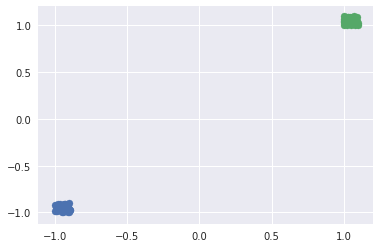

In [43]:
plt.scatter(input_1[:, 0], input_1[:, 1])
plt.scatter(input_2[:, 0], input_2[:, 1])

In [44]:
_, activity_1 = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=input_1)

In [45]:
_, activity_2 = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=input_2)

In [46]:
columns = ("vec", "resp")

a1 = activity_1.flatten()
l1 = ["v1"] * len(a1)
p1 = pd.DataFrame({"vec": l1, "resp": list(a1)})


a2 = activity_2.flatten()
l2 = ["v2"] * len(a2)
p2 = pd.DataFrame({"vec": l2, "resp": list(a2)})

acts = pd.concat((p1, p2))

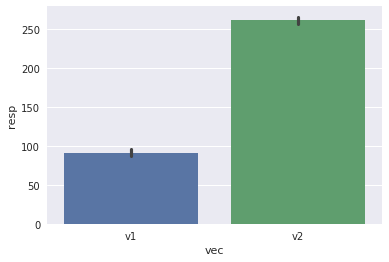

In [47]:
sns.barplot(x="vec", y="resp", data=acts)

# Apply to full vocab

In [4]:
dimensions = 64
n_neurons = 1000
seed = 8
p_fan = 0.85

In [5]:
vocab, fan1, fan1_vecs, fan2, fan2_vecs, foil1, foil1_vecs, foil2, foil2_vecs = make_alt_vocab(11, 11, dimensions, seed, norm=True)

## Baseline

In [77]:
with nengo.Network() as model:
    ens = nengo.Ensemble(n_neurons, dimensions)
sim = nengo.Simulator(model)

Building finished in 0:00:01.                                                   


In [78]:
_, base_act_1 = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=np.array(fan1_vecs))
_, base_act_2 = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=np.array(fan2_vecs))

In [81]:
columns = ("vec", "resp")

b1 = base_act_1.flatten()
l1 = ["b_fan1"] * len(b1)
p1 = pd.DataFrame({"vec": l1, "resp": list(b1)})


b2 = base_act_2.flatten()
l2 = ["b_fan2"] * len(b2)
p2 = pd.DataFrame({"vec": l2, "resp": list(b2)})

b_acts = pd.concat((p1, p2))

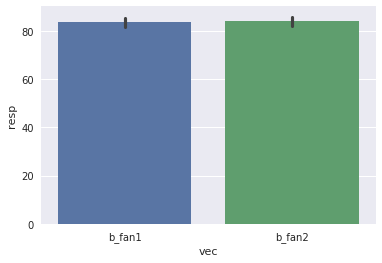

In [82]:
sns.barplot(x="vec", y="resp", data=b_acts)

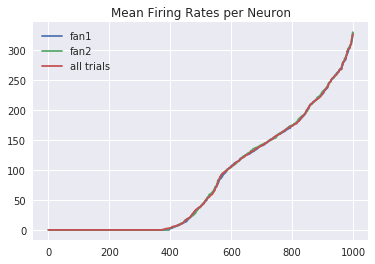

In [83]:
plt.title("Mean Firing Rates per Neuron")
plt.plot(np.sort(np.mean(base_act_1, axis=0)), label="fan1")
plt.plot(np.sort(np.mean(base_act_2, axis=0)), label="fan2")
plt.plot(np.sort(np.mean(np.concatenate((base_act_1, base_act_2)), axis=0)), label="all trials")
plt.legend()

### Check Representation

In [209]:
solver = nengo.solvers.LstsqL2()
dec, stat = solver(base_act_1, np.array(fan1_vecs))
print(np.sum(stat['rmses']))

0.138564972884


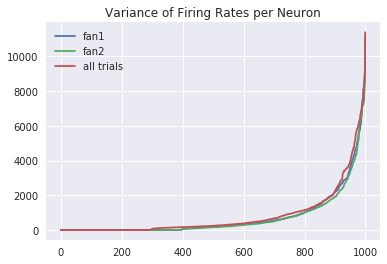

In [84]:
plt.title("Variance of Firing Rates per Neuron")
plt.plot(np.sort(np.var(base_act_1, axis=0)), label="fan1")
plt.plot(np.sort(np.var(base_act_2, axis=0)), label="fan2")
plt.plot(np.sort(np.var(np.concatenate((activity_1, activity_2)), axis=0)), label="all trials")
plt.legend()

Number of neurons basically firing for both vectors
428


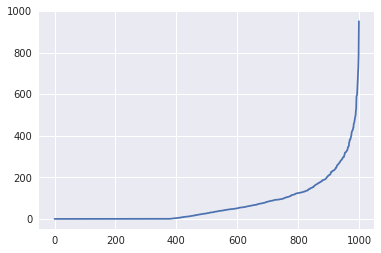

In [85]:
print("Number of neurons basically firing for both vectors")
fire_diff = np.sort(np.abs(np.sum(base_act_1, axis=0) - np.sum(base_act_2, axis=0)))
print(len(fire_diff[fire_diff < 10]))
plt.plot(fire_diff)

In [86]:
print("Number of neurons basically not firing for either vector")
fire_diff = np.sort(np.abs(np.sum(base_act_1, axis=0) + np.sum(base_act_2, axis=0)))
len(fire_diff[fire_diff < 10])

Number of neurons basically not firing for either vector


375

The similarity in firing rates means choosing intercepts would have no effect.

## Modified encoders (vectors)

In [194]:
encoders = np.zeros((n_neurons, dimensions))

fan1_end = int(n_neurons * p_fan)
print(fan1_end)

for n_i in range(fan1_end):
    encoders[n_i] = fan1_vecs[n_i % len(fan1)] + np.random.normal(size=dimensions)*0.1
print(n_i)

for n_i in range(fan1_end, n_neurons):
    encoders[n_i] = fan2_vecs[n_i % len(fan2)] + np.random.normal(size=dimensions)*0.1

print(n_i)

850
849
999


In [195]:
with nengo.Network() as model:
    ens = nengo.Ensemble(n_neurons, dimensions, encoders=encoders)
sim = nengo.Simulator(model)

In [197]:
#Stim = namedtuple("Stim", ['fan_num', 'foil_val', 'vecs'])

#stim_vecs = {"fan1": fan1_vecs, "fan2": fan2_vecs, "foil1": foil1_vecs, "foil2": foil2_vecs}

#def get_activities():
_, fan_act_1 = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=np.array(fan1_vecs))
_, fan_act_2 = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=np.array(fan2_vecs))
_, foil_act_1 = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=np.array(foil1_vecs))
_, foil_act_2 = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=np.array(foil2_vecs))

In [47]:
a1 = fan_act_1.flatten()
l1 = ["fan1"] * len(a1)
f1 = ["fan"] * len(a1)
p1 = pd.DataFrame({"vec": l1, "resp": list(a1), "foil": f1})


a2 = fan_act_2.flatten()
l2 = ["fan2"] * len(a2)
f2 = ["fan"] * len(a2)
p2 = pd.DataFrame({"vec": l2, "resp": list(a2), "foil": f2})

a1 = foil_act_1.flatten()
l1 = ["fan1"] * len(a1)
f1 = ["foil"] * len(a1) 
p3 = pd.DataFrame({"vec": l1, "resp": list(a1), "foil": f1})

a2 = foil_act_2.flatten()
l2 = ["fan2"] * len(a2)
f2 = ["foil"] * len(a2)
p4 = pd.DataFrame({"vec": l2, "resp": list(a2), "foil": f2})

acts = pd.concat((p1, p2, p3, p4))

(11000,)


(60, 110)

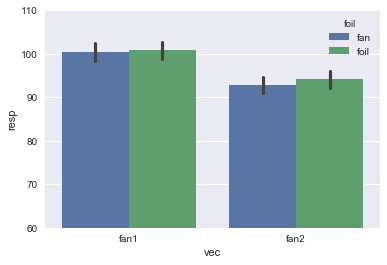

In [48]:
ax = sns.barplot(x="vec", y="resp", hue="foil", data=acts)
ax.set_ylim((60, 110))

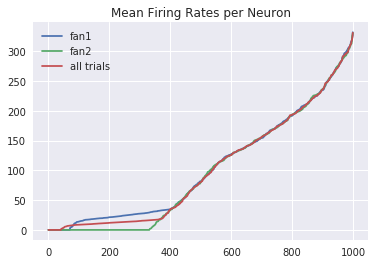

In [94]:
plt.title("Mean Firing Rates per Neuron")
plt.plot(np.sort(np.mean(activity_1, axis=0)), label="fan1")
plt.plot(np.sort(np.mean(activity_2, axis=0)), label="fan2")
plt.plot(np.sort(np.mean(np.concatenate((activity_1, activity_2)), axis=0)), label="all trials")
plt.legend()

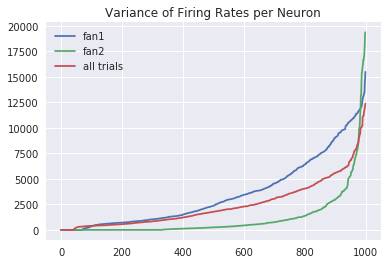

In [95]:
plt.title("Variance of Firing Rates per Neuron")
plt.plot(np.sort(np.var(activity_1, axis=0)), label="fan1")
plt.plot(np.sort(np.var(activity_2, axis=0)), label="fan2")
plt.plot(np.sort(np.var(np.concatenate((activity_1, activity_2)), axis=0)), label="all trials")
plt.legend()

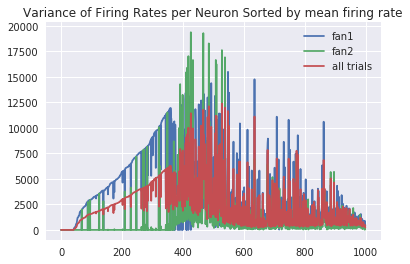

In [99]:
mean_act = np.argsort(np.mean(np.concatenate((activity_1, activity_2)), axis=0))

plt.title("Variance of Firing Rates per Neuron Sorted by mean firing rate")
plt.plot(np.var(activity_1, axis=0)[mean_act], label="fan1")
plt.plot(np.var(activity_2, axis=0)[mean_act], label="fan2")
plt.plot(np.var(np.concatenate((activity_1, activity_2)), axis=0)[mean_act], label="all trials")
plt.legend()

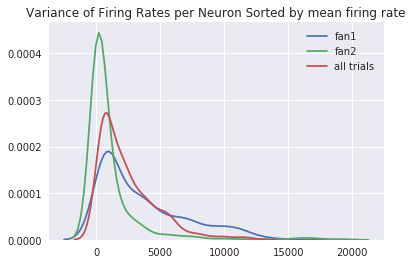

In [98]:
mean_act = np.argsort(np.mean(np.concatenate((activity_1, activity_2)), axis=0))

plt.title("Variance of Firing Rates per Neuron Sorted by mean firing rate")
sns.kdeplot(np.var(activity_1, axis=0)[mean_act], label="fan1")
sns.kdeplot(np.var(activity_2, axis=0)[mean_act], label="fan2")
sns.kdeplot(np.var(np.concatenate((activity_1, activity_2)), axis=0)[mean_act], label="all trials")
plt.legend()

Number of neurons basically firing for both vectors
100


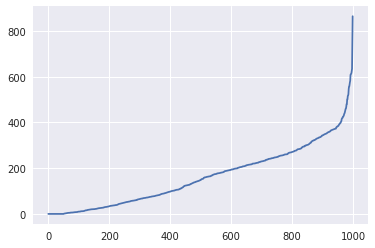

In [59]:
print("Number of neurons basically firing for both vectors")
fire_diff = np.sort(np.abs(np.sum(activity_1, axis=0) - np.sum(activity_2, axis=0)))
print(len(fire_diff[fire_diff < 10]))
plt.plot(fire_diff)

In [60]:
print("Number of neurons basically not firing for either vector")
fire_diff = np.sort(np.abs(np.sum(activity_1, axis=0) + np.sum(activity_2, axis=0)))
len(fire_diff[fire_diff < 10])

Number of neurons basically not firing for either vector


50

## Modified encoders (mean)

In [6]:
mean_fan1 = np.mean(fan1_vecs, axis=0)
print(mean_fan1.shape)
mean_fan2 = np.mean(fan2_vecs, axis=0)

(64,)


In [7]:
encoders = np.zeros((n_neurons, dimensions))

fan1_end = int(n_neurons * p_fan)
print(fan1_end)

for n_i in range(fan1_end):
    encoders[n_i] = mean_fan1 + np.random.normal(size=dimensions)*0.1
print(n_i)

for n_i in range(fan1_end, n_neurons):
    encoders[n_i] = mean_fan2 + np.random.normal(size=dimensions)*0.1

print(n_i)

850
849
999


In [8]:
with nengo.Network() as model:
    ens = nengo.Ensemble(n_neurons, dimensions, encoders=encoders)

In [9]:
sim = nengo.Simulator(model)

Building finished in 0:00:01.                                                                                                                 


In [10]:
_, fan_act_1 = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=np.array(fan1_vecs))
_, fan_act_2 = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=np.array(fan2_vecs))
_, foil_act_1 = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=np.array(foil1_vecs))
_, foil_act_2 = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=np.array(foil2_vecs))

In [11]:
columns = ("vec", "resp")

a1 = fan_act_1.flatten()
l1 = ["fan1"] * len(a1)
f1 = ["fan"] * len(a1)
p1 = pd.DataFrame({"vec": l1, "resp": list(a1), "foil": f1})


a2 = fan_act_2.flatten()
l2 = ["fan2"] * len(a2)
f2 = ["fan"] * len(a2)
p2 = pd.DataFrame({"vec": l2, "resp": list(a2), "foil": f2})

a1 = foil_act_1.flatten()
l1 = ["fan1"] * len(a1)
f1 = ["foil"] * len(a1) 
p3 = pd.DataFrame({"vec": l1, "resp": list(a1), "foil": f1})

a2 = foil_act_2.flatten()
l2 = ["fan2"] * len(a2)
f2 = ["foil"] * len(a2)
p4 = pd.DataFrame({"vec": l2, "resp": list(a2), "foil": f2})

acts = pd.concat((p1, p2, p3, p4))

(60, 110)

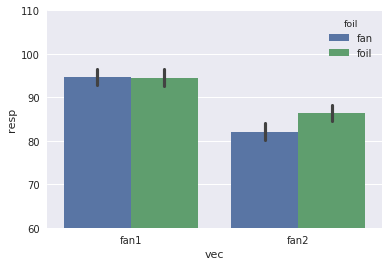

In [12]:
ax = sns.barplot(x="vec", y="resp", hue="foil", data=acts)
ax.set_ylim((60, 110))

### Check Representation

In [13]:
solver = nengo.solvers.LstsqL2()

In [14]:
fan_acts = np.concatenate((fan_act_1, fan_act_2))
fan_vecs = np.concatenate((np.array(fan1_vecs), np.array(fan2_vecs)))
print(fan_acts.shape)
print(fan_vecs.shape)
fan_dec, fan_stats = solver(fan_acts, fan_vecs)
print(np.sum(fan_stats['rmses']))

(22, 1000)
(22, 64)
0.337039609763


In [15]:
fan1_res = np.dot(fan_act_1, fan_dec)
fan1_rmse = rmse(fan1_res, fan1_vecs, axis=1)
print("fan1 target", fan1_rmse)
print(np.sum(fan1_rmse))

print()

fan2_res = np.dot(fan_act_2, fan_dec)
fan2_rmse = rmse(fan2_res, fan2_vecs, axis=1)
print("fan2 target", fan2_rmse)
print(np.sum(fan2_rmse))

fan1 target [ 0.00526314  0.00492267  0.00492892  0.00520096  0.00445942  0.00600563
  0.00476089  0.00434295  0.00442006  0.00456214  0.005464  ]
0.0543307801368

fan2 target [ 0.0055806   0.00553242  0.00599198  0.00551411  0.00547725  0.00580536
  0.00549505  0.00678575  0.00575035  0.00493465  0.00563862]
0.0625061492444


In [16]:
foil1_res = np.dot(foil_act_1, fan_dec)
foil1_rmse = rmse(foil1_res, foil1_vecs, axis=1)
print("fan1 foil", foil1_rmse)
print(np.sum(foil1_rmse))

foil2_res = np.dot(foil_act_2, fan_dec)
foil2_rmse = rmse(foil2_res, foil2_vecs, axis=1)
print("fan2 foil", foil2_rmse)
print(np.sum(foil2_rmse))

fan1 foil [ 0.07725856  0.08971112  0.0801697   0.06877615  0.06782255  0.05790446
  0.07980089  0.07514529  0.07189639  0.07535467  0.09181046]
0.835650239687
fan2 foil [ 0.062731    0.0367357   0.05604489  0.03968149  0.05020992  0.0512933
  0.03620345  0.05808753  0.05616665  0.03244575  0.04492188]
0.524521571369


In [17]:
all_pairs_text = fan1 + fan2 + foil1 + foil2

def pairs_text(test_vec, vocab):
    res_dict = {}

    for pair_text in all_pairs_text:
        tmp_pair = "+".join(pair_text)
        res_dict[tmp_pair] = np.abs(np.dot(test_vec, vocab.parse(tmp_pair).v))

    return sorted(res_dict.items(), key=lambda t: -t[1])

In [25]:
for res, vec in zip(list(fan1_res), list(fan1_vecs)):
    vec_res = pairs_text(vec, vocab)
    res_res = pairs_text(res, vocab)
    print(f"{vec_res[0]} = {res_res[:2]}")
    print(f"Diff: {vec_res[0][1] - res_res[0][1]:.{3}f}")

('F1_0+F1_1', 1.1829483858682834) = [('F1_0+F1_1', 1.1402723409219959), ('F1_0+F1_11', 0.60497351653669473)]
Diff: 0.043
('F1_2+F1_3', 1.4222818896051745) = [('F1_2+F1_3', 1.3731747567625932), ('F1_3+F1_14', 0.94105385879845982)]
Diff: 0.049
('F1_4+F1_5', 1.4100244612464934) = [('F1_4+F1_5', 1.3620505990028993), ('F1_4+F1_15', 0.80933852931964845)]
Diff: 0.048
('F1_6+F1_7', 1.4441837893653586) = [('F1_6+F1_7', 1.3914009080419425), ('F1_7+F1_18', 0.53384754370653853)]
Diff: 0.053
('F1_8+F1_9', 1.3752176516324692) = [('F1_8+F1_9', 1.3320240684474727), ('F1_9+F1_20', 0.82964924251471039)]
Diff: 0.043
('F1_10+F1_11', 1.4997864561086038) = [('F1_10+F1_11', 1.4364665947628663), ('F1_0+F1_11', 0.72769633036685655)]
Diff: 0.063
('F1_12+F1_13', 1.4388340400384574) = [('F1_12+F1_13', 1.3904448529949431), ('F1_2+F1_13', 0.72160430082412752)]
Diff: 0.048
('F1_14+F1_15', 1.5376337164287315) = [('F1_14+F1_15', 1.4932334611526641), ('F1_3+F1_14', 1.0763810671965697)]
Diff: 0.044
('F1_16+F1_17', 1.572

In [24]:
for res, vec in zip(list(fan2_res), list(fan2_vecs)):
    vec_res = pairs_text(vec, vocab)
    res_res = pairs_text(res, vocab)
    print(f"{vec_res[0]} = {res_res[:2]}")
    print(f"Diff: {vec_res[0][1] - res_res[0][1]:.{3}f}")

('F2_0+F2_1', 1.313052898195834) = [('F2_0+F2_1', 1.2722516085551137), ('F2_0+F2_5', 0.86665637137984164)]
Diff: 0.041
('F2_1+F2_2', 1.4336470502212708) = [('F2_1+F2_2', 1.3974534803097869), ('F2_1+F2_3', 0.83778167030477357)]
Diff: 0.036
('F2_2+F2_3', 1.397694849192046) = [('F2_2+F2_3', 1.3551977307831282), ('F2_1+F2_2', 0.84987351575913439)]
Diff: 0.042
('F2_3+F2_4', 1.2865162648228137) = [('F2_3+F2_4', 1.2468540578256375), ('F2_4+F2_5', 0.72586057603604837)]
Diff: 0.040
('F2_4+F2_5', 1.5169195156227944) = [('F2_4+F2_5', 1.4774236684343731), ('F2_5+F2_6', 0.85042135369609462)]
Diff: 0.039
('F2_5+F2_6', 1.394538035006915) = [('F2_5+F2_6', 1.3483451758555831), ('F2_4+F2_5', 0.91348374176613123)]
Diff: 0.046
('F2_6+F2_7', 1.527289232193306) = [('F2_6+F2_7', 1.4848254079396859), ('F2_0+F2_7', 0.77381802038031777)]
Diff: 0.042
('F2_7+F2_8', 1.3074867776404779) = [('F2_7+F2_8', 1.2550215084517264), ('F2_8+F2_9', 0.88960439407563607)]
Diff: 0.052
('F2_8+F2_9', 1.5089973410445843) = [('F2_8+

In [26]:
for res, vec in zip(list(foil1_res), list(foil1_vecs)):
    vec_res = pairs_text(vec, vocab)
    res_res = pairs_text(res, vocab)
    print(f"{vec_res[0]} = {res_res[:2]}")
    print(f"Diff: {vec_res[0][1] - res_res[0][1]:.{3}f}")

('F1_0+F1_11', 1.5499253552585093) = [('F1_0+F1_11', 0.85117584586317174), ('F1_10+F1_11', 0.62864188475468075)]
Diff: 0.699
('F1_1+F1_12', 1.2264522915007778) = [('F1_12+F1_13', 0.6212490263541659), ('F1_1+F1_12', 0.49925026661960192)]
Diff: 0.605
('F1_2+F1_13', 1.4774753289436278) = [('F1_2+F1_13', 0.91702181344960743), ('F1_12+F1_13', 0.82210791787661219)]
Diff: 0.560
('F1_3+F1_14', 1.6582193519408099) = [('F1_3+F1_14', 1.030678735434905), ('F1_2+F1_3', 0.76942740960044886)]
Diff: 0.628
('F1_4+F1_15', 1.4706267561575384) = [('F1_4+F1_15', 0.95179595213788715), ('F1_14+F1_15', 0.88012848870717209)]
Diff: 0.519
('F1_5+F1_16', 1.5183070609132325) = [('F1_5+F1_16', 1.110262132185645), ('F1_16+F1_17', 1.0071970387222604)]
Diff: 0.408
('F1_6+F1_17', 1.2882333604166356) = [('F1_16+F1_17', 0.75485357774481532), ('F1_6+F1_17', 0.67500925366675146)]
Diff: 0.533
('F1_7+F1_18', 1.4910003701467036) = [('F1_18+F1_19', 0.95196366717471814), ('F1_7+F1_18', 0.87987849074077806)]
Diff: 0.539
('F1_8+F

In [27]:
for res, vec in zip(list(foil2_res), list(foil2_vecs)):
    vec_res = pairs_text(vec, vocab)
    res_res = pairs_text(res, vocab)
    print(f"{vec_res[0]} = {res_res[:2]}")
    print(f"Diff: {vec_res[0][1] - res_res[0][1]:.{3}f}")

('F2_0+F2_2', 1.4683408706340337) = [('F2_0+F2_2', 0.92461839914329469), ('F2_0+F2_7', 0.75187381641126128)]
Diff: 0.544
('F2_0+F2_3', 1.3915424170593995) = [('F2_0+F2_3', 1.1274597467047482), ('F2_10+F2_0', 0.79505230546961891)]
Diff: 0.264
('F2_0+F2_4', 1.4243388774286829) = [('F2_0+F2_4', 1.0206467586056402), ('F2_4+F2_5', 0.83913533491371317)]
Diff: 0.404
('F2_0+F2_5', 1.5102603543919892) = [('F2_0+F2_5', 1.1830512728329621), ('F2_4+F2_5', 0.73936955714819086)]
Diff: 0.327
('F2_0+F2_6', 1.3061877003786986) = [('F2_0+F2_6', 0.99409636346025398), ('F2_6+F2_7', 0.86526953596084233)]
Diff: 0.312
('F2_0+F2_7', 1.5421900555583159) = [('F2_0+F2_7', 1.1595502213668873), ('F2_6+F2_7', 0.78084428885516144)]
Diff: 0.383
('F2_0+F2_8', 1.4518771268330402) = [('F2_0+F2_8', 1.2004253300537748), ('F2_8+F2_9', 0.84331448984547441)]
Diff: 0.251
('F2_0+F2_9', 1.5270078277013095) = [('F2_0+F2_9', 1.0540986521627489), ('F2_8+F2_9', 0.77310095142878732)]
Diff: 0.473
('F2_1+F2_3', 1.5486942133865731) = [

In [22]:
all_acts = np.concatenate((fan_act_1, fan_act_2, foil_act_1, foil_act_2))
all_vecs = np.concatenate((np.array(fan1_vecs), np.array(fan2_vecs), np.array(foil1_vecs), np.array(foil2_vecs)))
all_dec, all_stats = solver(all_acts, all_vecs)
print(np.sum(all_stats['rmses']))

0.617614653119


### Other metrics

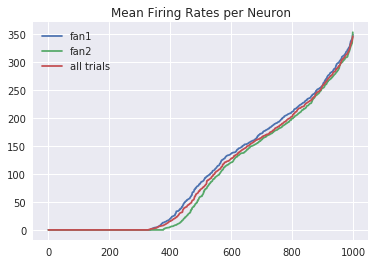

In [108]:
plt.title("Mean Firing Rates per Neuron")
plt.plot(np.sort(np.mean(activity_1, axis=0)), label="fan1")
plt.plot(np.sort(np.mean(activity_2, axis=0)), label="fan2")
plt.plot(np.sort(np.mean(np.concatenate((activity_1, activity_2)), axis=0)), label="all trials")
plt.legend()

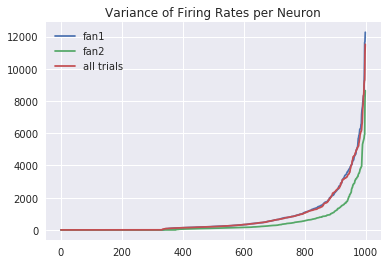

In [109]:
plt.title("Variance of Firing Rates per Neuron")
plt.plot(np.sort(np.var(activity_1, axis=0)), label="fan1")
plt.plot(np.sort(np.var(activity_2, axis=0)), label="fan2")
plt.plot(np.sort(np.var(np.concatenate((activity_1, activity_2)), axis=0)), label="all trials")
plt.legend()

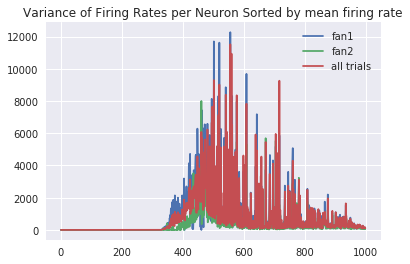

In [112]:
mean_act = np.argsort(np.mean(np.concatenate((activity_1, activity_2)), axis=0))

plt.title("Variance of Firing Rates per Neuron Sorted by mean firing rate")
plt.plot(np.var(activity_1, axis=0)[mean_act], label="fan1")
plt.plot(np.var(activity_2, axis=0)[mean_act], label="fan2")
plt.plot(np.var(np.concatenate((activity_1, activity_2)), axis=0)[mean_act], label="all trials")
plt.legend()

Number of neurons basically firing for both vectors
329


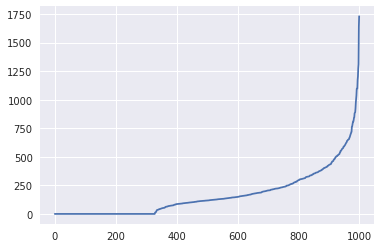

In [110]:
print("Number of neurons basically firing for both vectors")
fire_diff = np.sort(np.abs(np.sum(activity_1, axis=0) - np.sum(activity_2, axis=0)))
print(len(fire_diff[fire_diff < 10]))
plt.plot(fire_diff)

In [111]:
print("Number of neurons basically not firing for either vector")
fire_diff = np.sort(np.abs(np.sum(activity_1, axis=0) + np.sum(activity_2, axis=0)))
len(fire_diff[fire_diff < 10])

Number of neurons basically not firing for either vector


329